In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import randn
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

pd.set_option('display.max_columns', None)

df = pd.read_csv('dataset/diabetes_binary_health_indicators_BRFSS2021.csv')
# Assuming df is your DataFrame and "Diabetes_binary" is your target column
class_0 = df[df.Diabetes_binary == 0]
class_1 = df[df.Diabetes_binary == 1]

# Downsample class 0 to match the number of instances in class 1
class_0_downsampled = class_0.sample(len(class_1))

# Concatenate the downsampled class 0 with class 1
data = pd.concat([class_0_downsampled, class_1], axis=0)
print (data.shape)
print (data.tail())
print (data.columns)

(67136, 22)
        Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
236343              1.0       1       0.0          1  27.0     0.0     0.0   
236355              1.0       1       1.0          1  26.0     0.0     0.0   
236362              1.0       1       1.0          1  32.0     0.0     0.0   
236369              1.0       1       1.0          1  33.0     0.0     0.0   
236373              1.0       1       1.0          1  21.0     0.0     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  \
236343                   0.0             1       1        1   
236355                   0.0             0       1        1   
236362                   1.0             1       0        0   
236369                   0.0             0       0        1   
236373                   0.0             1       1        1   

        HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  \
236343                  0              1          0.0      3.0  

In [2]:
features = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 
                 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 
                 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 
                 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
label = ['Diabetes_binary']
X = data[features]
y = data[label] 

In [3]:
X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X, y, test_size=0.30, random_state=42)
clf_true = RandomForestClassifier(n_estimators=100)
clf_true.fit(X_true_train,y_true_train)
y_true_pred=clf_true.predict(X_true_test)
print("Base Accuracy:",metrics.accuracy_score(y_true_test, y_true_pred))
print("Base classification report:",metrics.classification_report(y_true_test, y_true_pred))

c:\Users\ensar\Desktop\Diabetes-Prediction\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Base Accuracy: 0.72762027704682
Base classification report:               precision    recall  f1-score   support

         0.0       0.74      0.70      0.72     10042
         1.0       0.72      0.76      0.74     10099

    accuracy                           0.73     20141
   macro avg       0.73      0.73      0.73     20141
weighted avg       0.73      0.73      0.73     20141



In [4]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [5]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    
    return X, y

In [6]:
# generate n real samples with class labels; We randomly select n samples from the real data
def generate_real_samples(n):
    X = data.sample(n)
    y = np.ones((n, 1))
    return X, y

In [7]:
def define_generator(latent_dim, n_outputs=22):
    model = Sequential()
    model.add(Dense(15, activation='relu',  kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(n_outputs, activation='linear'))
    return model

In [8]:
generator1 = define_generator(10, 22)
generator1.summary()

c:\Users\ensar\Desktop\Diabetes-Prediction\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 15)             │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 22)             │           682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,327 (5.18 KB)

 Trainable params: 1,327 (5.18 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
def define_discriminator(n_inputs=22):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
discriminator1 = define_discriminator(22)
discriminator1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 25)             │           575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,926 (7.52 KB)

 Trainable params: 1,926 (7.52 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [12]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
    # plot loss
    plt.subplot(1, 1, 1)
    plt.plot(d_hist, label='d')
    plt.plot(g_hist, label='gen')
    plt.show()
    plt.close()

In [13]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=5000, n_batch=128, n_eval=200):
    # determine half the size of one batch, for updating the  discriminator
    half_batch = int(n_batch / 2)
    d_history = []
    g_history = []
    # manually enumerate epochs
    for epoch in range(n_epochs):
    
      # prepare real samples
      x_real, y_real = generate_real_samples(half_batch)
      # prepare fake examples
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator
      d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
      d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      # prepare points in latent space as input for the generator
      x_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
      print('EPOCH: ' + str(epoch+1))
      d_history.append(d_loss)
      g_history.append(g_loss_fake)
    plot_history(d_history, g_history)
    g_model.save('trained_generated_model5k.h5')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


c:\Users\ensar\Desktop\Diabetes-Prediction\venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


EPOCH: 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
EPOCH: 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
EPOCH: 3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
EPOCH: 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
EPOCH: 5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
EPOCH: 6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
EPOCH: 7
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
EPOCH: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
EPOCH: 9
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
EPOCH: 10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
EPOCH: 11
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
EPOCH: 12
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
EPOCH: 13
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
EPOCH: 14
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
EPOCH: 15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
EPOCH: 16
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
EPOCH: 17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
EPOCH: 18
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
EPOCH: 19
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
EPOCH: 20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
EPOCH: 21
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

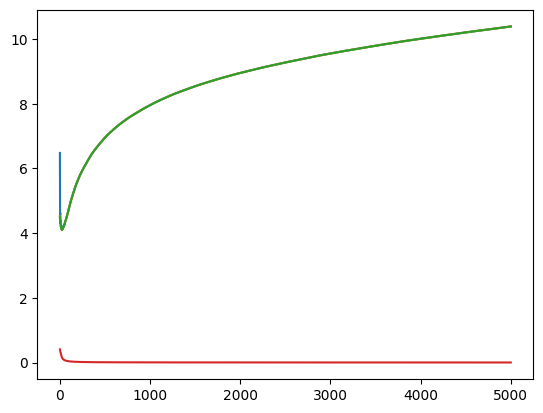

In [14]:
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [22]:
from keras.models import load_model
model =load_model('trained_generated_model5k.h5')

latent_points = generate_latent_points(10, 750)
X = model.predict(latent_points)
data_fake = pd.DataFrame(data=X,  columns=['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 
                 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 
                 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 
                 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'])
data_fake.head()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,5.237195,1.898192,2.917619,7.488943,-4.802912,-9.444731,3.941151,6.620588,-4.869457,-0.091806,-9.542565,-8.982191,-9.417625,-5.798353,-10.111421,-7.931289,-2.748528,5.573586,-2.342713,-2.790036,-7.217017,5.729692
1,4.863846,2.089808,2.896796,5.466969,-4.983634,-8.970613,4.127901,4.530083,-3.239319,-1.333240,-7.032640,-6.295349,-7.650000,-3.992295,-8.487579,-7.218719,-2.230664,4.447819,-1.333348,-2.854648,-5.724188,4.847084
2,5.130659,2.225855,4.069490,5.779854,-5.052260,-9.454981,5.157633,6.486923,-4.829473,-1.283902,-10.128825,-8.556998,-9.507010,-7.491601,-9.078212,-6.752908,-2.275319,6.064370,-2.144961,-2.337268,-7.604920,6.666424
3,3.754454,1.824136,2.721281,4.206717,-3.811335,-6.546422,2.616328,3.314197,-3.058525,-0.931626,-6.208177,-5.620162,-6.457590,-4.359106,-5.923600,-4.873304,-1.155285,3.711391,-1.441177,-1.985210,-4.710235,3.215463
4,3.999435,2.053819,3.260107,4.482437,-3.616350,-7.710379,4.223808,4.981568,-3.334158,-1.358665,-6.790751,-5.829714,-6.855074,-4.779706,-7.145523,-5.430347,-1.680292,4.224468,-1.187647,-1.814876,-5.754660,4.717213


In [23]:
binary_columns = ['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 
                 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 
                 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

for col in binary_columns:
    mean = data_fake[col].mean()
    data_fake[col] = data_fake[col] > mean
    data_fake[col] = data_fake[col].astype(int)

In [24]:
features = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 
                 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 
                 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 
                 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
label = ['Diabetes_binary']
X_fake_created = data_fake[features]
y_fake_created = data_fake[label]

In [25]:
X_fake_created.head(100)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,0,1,-4.802912,0,0,1,0,1,0,0,0,0,-10.111421,-7.931289,-2.748528,1,0,-2.790036,-7.217017,5.729692
1,0,0,0,-4.983634,0,1,0,1,0,1,1,1,1,-8.487579,-7.218719,-2.230664,0,1,-2.854648,-5.724188,4.847084
2,0,1,0,-5.052260,0,1,1,0,0,0,0,0,0,-9.078212,-6.752908,-2.275319,1,0,-2.337268,-7.604920,6.666424
3,0,0,0,-3.811335,1,0,0,1,0,1,1,1,1,-5.923600,-4.873304,-1.155285,0,1,-1.985210,-4.710235,3.215463
4,0,0,0,-3.616350,1,1,0,0,0,1,1,1,1,-7.145523,-5.430347,-1.680292,0,1,-1.814876,-5.754660,4.717213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,1,0,-4.029088,1,0,0,1,0,0,1,1,1,-5.427557,-5.528289,-2.502057,0,1,-1.699606,-6.159139,4.979369
96,0,0,0,-3.181931,1,1,1,0,0,1,1,1,0,-6.709157,-5.565489,-1.971817,0,0,-1.386321,-6.030282,5.559591
97,1,1,1,-5.163495,0,1,1,0,0,0,0,0,0,-11.919944,-9.868826,-3.526154,1,1,-2.787102,-10.208737,9.335194
98,0,0,0,-3.078108,1,0,0,1,1,1,1,1,1,-3.853985,-4.613853,-2.016258,0,1,-1.758760,-3.565921,2.907037


In [19]:
y_fake_created.head()

,Diabetes_binary
0,1
1,0
2,0
3,0
4,0
